In [1]:
##############################Imports###################################
import os
import sys
root_path = os.path.join(os.path.expanduser('~'), 'bnelearn')
if root_path not in sys.path:
    sys.path.append(root_path)

import time
from timeit import default_timer as timer
from functools import partial

import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

from bnelearn.strategy import NeuralNetStrategy, ClosureStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import LLLLGGAuction, CombinatorialAuction
from bnelearn.learner import ESPGLearner
from bnelearn.environment import AuctionEnvironment

from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.rcParams['figure.figsize'] = [10, 7]
    
cuda = False #torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

# Use specific cuda gpu if desired (i.e. for running multiple experiments in parallel)
specific_gpu = 5
if cuda and specific_gpu:
    torch.cuda.set_device(specific_gpu)

print(device)
if cuda: print(torch.cuda.current_device())

##################################Settings##################################
# log in notebook folder
# alternative for shared access to experiments:
#log_root = os.path.abspath('/srv/bnelearn/experiments')
log_root = os.path.abspath('.')
run_comment = 'espg'
save_figure_data_to_disc = False
save_figure_to_disc = False

## Experiment setup
n_players = 6
n_items = 8
# valuation distribution
# both players should have same lower bound
u_lo =   0.0
u0_hi = 1.
u1_hi = 2.
u_his = [u0_hi, u0_hi, u0_hi, u0_hi, u1_hi, u1_hi]

def strat_to_bidder(strategy, batch_size, player_position):
    return Bidder.uniform(u_lo, u_his[player_position], strategy, n_items = 2, player_position=player_position, batch_size = batch_size, cuda = cuda)

## Environment settings
#training batch size
batch_size = 2**8
eval_batch_size = 2**25
epoch = 2

# strategy model architecture
input_length = 2
hidden_nodes = [2]#5, 5]
hidden_activations = [nn.SELU()]#, nn.SELU()]#, nn.SELU()]


learner_hyperparams = {
    'population_size':16,
    'sigma': 1.,
    'scale_sigma_by_model_size': True
}

### Optimizer hyperparams
# SGD standards
    #'lr': 1e-3,
    #'momentum': 0.7
# Adam standards:
    # 'lr': 1e-3
    # 'betas': (0.9, 0.999), #coefficients for running avgs of grad and square grad
    # 'eps': 1e-8 , # added to denominator for numeric stability
    # 'weight_decay': 0, #L2-decay
    # 'amsgrad': False #whether to use amsgrad-variant
optimizer_type = torch.optim.SGD
optimizer_hyperparams ={    
    'lr': 1e-3,
    'momentum': 0.9
}

# plot and log training options
plot_epoch = 10
plot_points = min(100, batch_size)

plot_xmin = u_lo
plot_xmax = u1_hi
plot_ymin = 0
plot_ymax = 4

############################Setting up the Environment##########################
# for evaluation
# helper constant
c = 1 / (u0_hi - u_lo)**2 - 1 / (u1_hi - u_lo)**2

def log_once(writer, e):
    """Everything that should be logged only once on initialization."""
    for i in range(n_players):
        #writer.add_scalar('debug_players/p{}_model_parameters'.format(i), n_parameters[i], e)
        #writer.add_scalar('debug/model_parameters', sum(n_parameters), e)
        writer.add_scalar('debug/eval_batch_size', eval_batch_size, e)
        writer.add_text('hyperparams/neural_net_spec', str(model_1), 0)    
        #writer.add_scalar('debug/eval_batch_size', eval_batch_size, e)
        #writer.add_graph(model_1, env.agents[0].valuations)    

def setup_custom_scalar_plots(writer):    
    ## define layout first, then call add_custom_scalars once
    layout = {'eval':
        {
            #'Loss vs BNE relative': ['Multiline',
            #                         ['eval_players/p{}_epsilon_relative'.format(i) for i in range(n_players)]]
            #'How to make a margin chart': ['Margin', ['tag_mean', 'tag_min', 'tag_max']]
        }
    }    
    writer.add_custom_scalars(layout) 

def log_once(writer, e):
    """Everything that should be logged only once on initialization."""
    pass
    #for i in range(n_players):
        #writer.add_scalar('debug_players/p{}_model_parameters'.format(i), n_parameters[i], e)
    #writer.add_scalar('debug/model_parameters', sum(n_parameters), e)
    #writer.add_scalar('debug/eval_batch_size', eval_batch_size, e)
    #for a in agents:
        #writer.add_text('hyperparams/neural_net_spec', str(a.strategy), 0)    
    #writer.add_scalar('debug/eval_batch_size', eval_batch_size, e)
    #writer.add_graph(model_l1, env.agents[0].valuations)    

def log_hyperparams(writer, e):
#     writer.add_scalar('hyperparams/batch_size', batch_size, e)
#     writer.add_scalar('hyperparams/batch_size', batch_size, e)
#     writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
#     writer.add_scalar('hyperparams/momentum', momentum, e)
#     writer.add_scalar('hyperparams/sigma', sigma, e)
#     writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)
    pass
        
def plot_bid_function(fig, valuations, bids, writer=None, e=None,
                      plot_points=plot_points,
                      save_vectors_to_disc=save_figure_data_to_disc,
                      save_png_to_disc = False):
    #$$$TODO: Removed [:plot_points] for now to get it running. Include (for batch!?) again.
    #plot_points = min(plot_points, len(v1), len(v2))
    # subsample points and plot    
    v_print = [None] * 2
    b_print = [None] * 2
    #for k in range(len(valuations)):
    #    v_print[k] = [None] * len(valuations[k][0])
    #    b_print[k] = [None] * len(valuations[k][0])
     #   for k2 in range(len(valuations[k][0])):
    #        v_print[k][k2] = valuations[k][:,k2].detach().cpu().numpy()
    #        b_print[k][k2] = bids[k][:,k2].detach().cpu().numpy()
    for k in range(len(valuations)):
        for k2 in range(len(valuations[k][0])):
            if k==0:
                v_print[k2] = valuations[k][:,k2].detach().cpu().numpy()
                b_print[k2] = bids[k][:,k2].detach().cpu().numpy()
            else:
                v_print[k2] = np.concatenate((v_print[k2],valuations[k][:,k2].detach().cpu().numpy()))
                b_print[k2] = np.concatenate((b_print[k2],bids[k][:,k2].detach().cpu().numpy()))
        
    fig = plt.gcf()
    plt.cla()
    plt.xlim(plot_xmin, plot_xmax)
    plt.ylim(plot_ymin, plot_ymax)
    plt.xlabel('valuation')
    plt.ylabel('bid')
    plt.text(plot_xmin + 1, plot_ymax - 1, 'iteration {}'.format(e))
    plt.plot(v_print[0], b_print[0], 'bo')
    #plt.plot(v_print[0][0], b_print[0][0], 'bo', v_print[1][0], b_print[1][0], 'go', v_print[2][0], b_print[2][0], 'ro', v_print[3][0], b_print[3][0], 'yo', v_print[4][0], b_print[4][0], 'g-', v_print[5][0], b_print[5][0], 'b-')
    #plt.plot(v_print[0][1], b_print[0][1], 'bo', v_print[1][1], b_print[1][1], 'go', v_print[2][1], b_print[2][1], 'ro', v_print[3][1], b_print[3][1], 'yo', v_print[4][1], b_print[4][1], 'g-', v_print[5][1], b_print[5][1], 'b-')
    if is_ipython:
        display.clear_output(wait=True)
    display.display(fig)
    plt.show()
    plt.plot(v_print[1], b_print[1], 'bo')
    display.display(fig)
    plt.show()
    if save_png_to_disc:
        plt.savefig(os.path.join(logdir, 'png', run_name + f'_{e:05}.png'))
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

##########################################################################
# initialize models
model_0 = NeuralNetStrategy(input_length,                            
                            hidden_nodes = hidden_nodes,
                            hidden_activations = hidden_activations,
                            output_length = 2).to(device)#,
                            #ensure_positive_output = torch.tensor([float(u_lo), float(u_lo)])).to(device)
   

model_1 = NeuralNetStrategy(input_length,
                            hidden_nodes = hidden_nodes,
                            hidden_activations = hidden_activations,
                            output_length = 2).to(device)
                            #ensure_positive_output = torch.tensor([float(u_lo), float(u_lo)])).to(device)

n_parameters = [sum([p.numel() for p in model_0.parameters()]),sum([p.numel() for p in model_0.parameters()])]

bidder_0 = strat_to_bidder(model_0, batch_size, player_position=0)
bidder_1 = strat_to_bidder(model_0, batch_size, player_position=1)
bidder_2 = strat_to_bidder(model_0, batch_size, player_position=2)
bidder_3 = strat_to_bidder(model_0, batch_size, player_position=3)
bidder_4 = strat_to_bidder(model_1, batch_size, player_position=4)
bidder_5 = strat_to_bidder(model_1, batch_size, player_position=5)

bidders = [bidder_0,bidder_1,bidder_2,bidder_3,bidder_4,bidder_5]

mechanism = LLLLGGAuction(cuda = cuda)
env = AuctionEnvironment(mechanism,
                  agents = bidders,
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_player_closure = strat_to_bidder
                 )
learner_0 = ESPGLearner(
    model = model_0,
    environment = env,
    hyperparams = learner_hyperparams,
    optimizer_type = optimizer_type,
    optimizer_hyperparams = optimizer_hyperparams)

learner_1 = ESPGLearner(
    model = model_1,
    environment = env,
    hyperparams = learner_hyperparams,
    optimizer_type = optimizer_type,
    optimizer_hyperparams = optimizer_hyperparams)



print(model_0)
print('Total parameters: ' + str(n_parameters))

v = [None] * len(bidders)
b = [None] * len(bidders)
for k, bidder in enumerate(bidders):
    bidder.draw_valuations_()
    v[k] = bidder.valuations.squeeze(0)
    b[k] = bidder.get_action().squeeze(0)

fig = plt.figure()
plot_bid_function(fig, v, b, writer=None,e=0) 

###################################################Training####################################################
print(log_root)

if os.name == 'nt': raise ValueError('The run_name may not contain : on Windows! (change datetime format to fix this)') 
run_name = time.strftime('%Y-%m-%d %a %H:%M')
if run_comment:
    run_name = run_name + ' - ' + str(run_comment)
logdir = os.path.join(log_root, 'LLLLGG', 'asymmetric', 'uniform', str(n_players) + 'p', run_name)
print(logdir)
os.makedirs(logdir, exist_ok=True)
if save_figure_to_disc:
    os.mkdir(os.path.join(logdir, 'png'))

plt.rcParams['figure.figsize'] = [10, 7]


<Figure size 1000x700 with 1 Axes>

<Figure size 1000x700 with 1 Axes>

<Figure size 1000x700 with 1 Axes>

<Figure size 1000x700 with 1 Axes>

/home/sutterer/bnelearn/notebooks
/home/sutterer/bnelearn/notebooks/LLLLGG/asymmetric/uniform/6p/2019-10-23 Wed 13:33 - espg


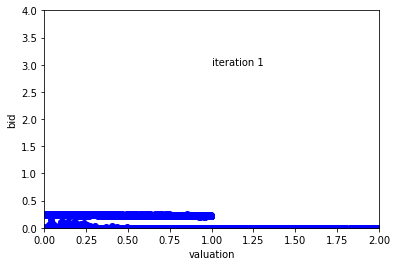

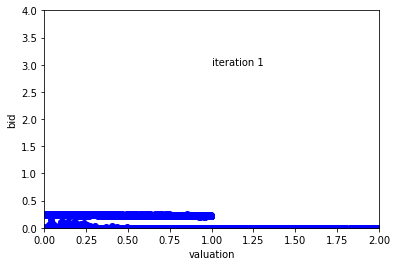

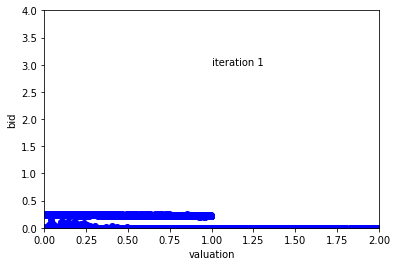

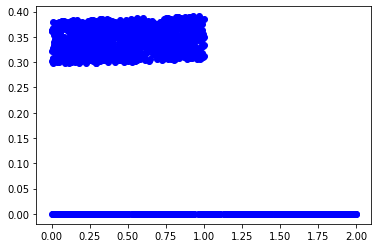

2


In [ ]:
%%prun

with SummaryWriter(logdir, flush_secs=60) as writer:
       
    
    overhead_mins = 0
    torch.cuda.empty_cache()
    log_once(writer, 0)
    fig = plt.figure()
    


    for e in range(epoch+1):
        print(e)

        # always: do optimizer step
        utility_0 = learner_0.update_strategy_and_evaluate_utility()
        utility_1 = learner_1.update_strategy_and_evaluate_utility()
        
        #logging 
        start_time = timer()
        utilities = torch.tensor([utility_0, utility_1])
            
        # plot current function output
            
        v = [None] * len(bidders)
        b = [None] * len(bidders)
        for k, bidder in enumerate(bidders):
            bidder.draw_valuations_()
            v[k] = bidder.valuations#.squeeze(0)
            b[k] = bidder.get_action()#.squeeze(0)
        fig = plt.figure()
        
        #print(('Epoch: {}: Model utility in learning env:'+'\t{:.5f}'*n_players).format(e, *utilities))            
        #print("Epoch {}: \tutilities: \t p0: {:.3f} \t p1: {:.3f}".format(e, utility_0, utility_1))
        plot_bid_function(fig, v, b, writer,e,
                              save_png_to_disc=save_figure_to_disc)  
        
        elapsed = timer() - start_time
        overhead_mins = overhead_mins + elapsed/60
        writer.add_scalar('debug/overhead_mins', overhead_mins, e)